<a href="https://colab.research.google.com/github/skywalker00001/DL_ASSIGNMENT/blob/main/myDL_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = 'drive/MyDrive/DL_assignment/'

Mounted at /content/drive


# 1. Network and Dataset
Resnet18:

CIFAR-10:

In [2]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import json
from pathlib import Path
import pathlib
import math

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import time

In [6]:
# Global Settings
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
CIFAR10_CLASSES = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RESULTS = defaultdict(list)
RESULT_FILENAME = 'DL_result.json'

print(DEVICE)

cpu


In [5]:

# load DL_result.json
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)


In [6]:
print(len(RESULTS))

8


In [7]:
# Load Dataset and Dataloader

# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)
"""
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
"""

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


"\nclasses = ('plane', 'car', 'bird', 'cat', 'deer',\n           'dog', 'frog', 'horse', 'ship', 'truck')\n"

In [8]:
none_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])
none_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=none_train)
none_trainloader = torch.utils.data.DataLoader(
    none_trainset, batch_size=128, shuffle=True, num_workers=2)

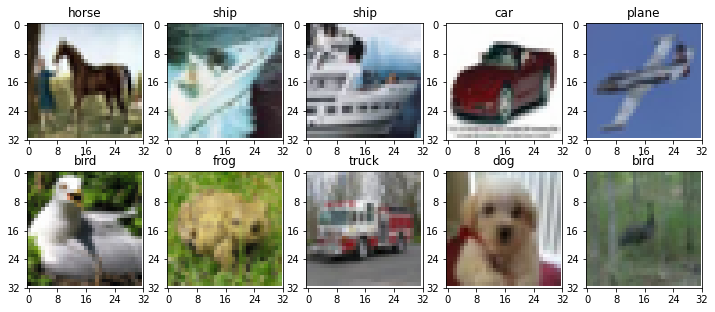

In [9]:
# show image

def imshow(imgs, titles=None, pic_size=(10, 10)):
    """Imshow for Tensor."""

    fig = plt.figure(figsize=pic_size)
    columns = 5
    rows = math.ceil(len(titles) / columns)
    for i in range(1, len(titles) + 1):
        img = imgs[i-1]
        img = img.numpy().transpose((1, 2, 0))
        mean = CIFAR10_MEAN
        std = CIFAR10_STD
        img = std * img + mean
        img = np.clip(img, 0, 1) # limit img value in (0, 1)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i-1])
        plt.xticks(np.arange(0, 33, 8))
        plt.yticks(np.arange(0, 33, 8))
    plt.subplots_adjust(right=2)
    plt.show(0.001)  


# Get a batch of training data
# inputs contains b images because batch_size=b for the dataloaders
imgs, lbls = next(iter(none_trainloader))
img_samples = imgs[0:10]
lbls_samples = lbls[0:10]


imshow(img_samples, titles=[CIFAR10_CLASSES[x] for x in lbls_samples], pic_size=(5, 5))

# Define Resnet Module

In [12]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


# Train and Test

In [13]:
# Training
def train(epoch, net, criterion, trainloader, optimizer, device, scheduler=None):
    device = device
    optimizer = optimizer
    scheduler = scheduler

    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        #print(batch_idx)
        #if (batch_idx+1) % 50 == 0:
        #    print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))
    if (scheduler != None):
        scheduler.step()
        
    return train_loss/(batch_idx+1), 100.*correct/total

In [14]:
def test(epoch, net, criterion, testloader, device):
    device = device
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



# Define helper funciton

In [15]:
# Helper function to print time between epochs
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
def save_checkpoint(net, acc, epoch, fname):
    # Save checkpoint.
    print('Saving' + fname)
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir(root + 'checkpoint'):
        os.mkdir(root + 'checkpoint')
    torch.save(state, root + 'checkpoint/' + fname + '.ckpt')

In [17]:
def load_pt_file(fname, device='cpu'):
    """Returns saved .(ck)pt file fields."""
    fname = root +'checkpoint/' + fname + '.ckpt'
    fname = str(pathlib.Path(fname).expanduser())
    data = torch.load(fname, map_location=device)
    return data

'''
# load the best dumped model
data = load_pt_file(models_dir + '/' + best_model_name)
weights = data['model']
model.load_state_dict(weights, strict=False)

save_checkpoint(res18, test_acc[-1], epoch300, 'LR_1')
data = load_pt_file('LR_1')
'''

"\n# load the best dumped model\ndata = load_pt_file(models_dir + '/' + best_model_name)\nweights = data['model']\nmodel.load_state_dict(weights, strict=False)\n\nsave_checkpoint(res18, test_acc[-1], epoch300, 'LR_1')\ndata = load_pt_file('LR_1')\n"

# Main Body

In [18]:
# Define config
config = {
    'lr': [0.001, 0.01, 0.1],
    'momentum': 0.9,
    'weight_decay': [5e-4, 1e-2],
    'epoch': [15, 300]
}

# 3. 3. Learning rate

In [15]:
'''
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)

# optimizer = 0.001, 0.01, 0.1
optimizer1 = optim.SGD(res18.parameters(), lr=config['lr'][0], momentum=config['momentum'])
optimizer2 = optim.SGD(res18.parameters(), lr=config['lr'][1], momentum=config['momentum'])
optimizer3 = optim.SGD(res18.parameters(), lr=config['lr'][2], momentum=config['momentum'])

#                      momentum=config['momentum'], weight_decay=config['weight_decay'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
'''

"\nres18 = ResNet18().to(DEVICE)\ncriterion = nn.CrossEntropyLoss().to(DEVICE)\n\n# optimizer = 0.001, 0.01, 0.1\noptimizer1 = optim.SGD(res18.parameters(), lr=config['lr'][0], momentum=config['momentum'])\noptimizer2 = optim.SGD(res18.parameters(), lr=config['lr'][1], momentum=config['momentum'])\noptimizer3 = optim.SGD(res18.parameters(), lr=config['lr'][2], momentum=config['momentum'])\n\n#                      momentum=config['momentum'], weight_decay=config['weight_decay'])\n# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)\n"

## 1. lr_1=0.001

In [16]:
%%time
epoch15 = config['epoch'][0]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer1 = optim.SGD(res18.parameters(), lr=config['lr'][0], momentum=config['momentum'])

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch15+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, trainloader, optimizer1, DEVICE, None) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()

# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)


RESULTS['LR_1'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)

save_checkpoint(res18, test_acc[-1], epoch15, 'LR_1')

Epoch: 001 | Epoch Time: 0m 39s
	Train Loss: 1.6227 | Train Acc: 40.26%
	Valid Loss: 1.5101 | Valid Acc: 45.45%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 1.1887 | Train Acc: 57.16%
	Valid Loss: 1.1925 | Valid Acc: 58.00%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 0.9698 | Train Acc: 65.33%
	Valid Loss: 0.9309 | Valid Acc: 67.23%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 0.8240 | Train Acc: 71.00%
	Valid Loss: 0.8559 | Valid Acc: 70.42%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.7202 | Train Acc: 74.65%
	Valid Loss: 0.7303 | Valid Acc: 75.03%

Epoch: 006 | Epoch Time: 0m 38s
	Train Loss: 0.6434 | Train Acc: 77.45%
	Valid Loss: 0.7693 | Valid Acc: 74.68%

Epoch: 007 | Epoch Time: 0m 38s
	Train Loss: 0.5934 | Train Acc: 79.26%
	Valid Loss: 0.6491 | Valid Acc: 77.73%

Epoch: 008 | Epoch Time: 0m 38s
	Train Loss: 0.5434 | Train Acc: 81.12%
	Valid Loss: 0.6410 | Valid Acc: 77.62%

Epoch: 009 | Epoch Time: 0m 38s
	Train Loss: 0.5063 | Train Acc: 82.63%
	Valid Loss: 0.6410 | Va

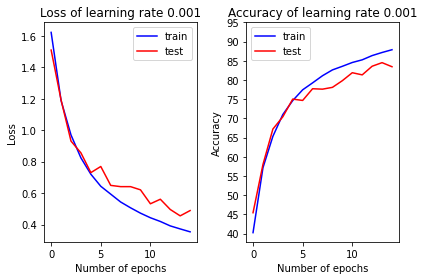

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of learning rate 0.001")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))
#ax[0].set_xticks(np.arange(0, 300, 50))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of learning rate 0.001")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))
#ax[1].set_xticks(np.arange(0, 300, 50))

fig.tight_layout()
plt.show()

## 2. LR_2 = 0.01

In [18]:
%%time
epoch15 = config['epoch'][0]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer2 = optim.SGD(res18.parameters(), lr=config['lr'][1], momentum=config['momentum'])

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch15+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, trainloader, optimizer2, DEVICE, None) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()
    
# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)

RESULTS['LR_2'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)
save_checkpoint(res18, test_acc[-1], epoch15, 'LR_2')

Epoch: 001 | Epoch Time: 0m 38s
	Train Loss: 1.4094 | Train Acc: 48.74%
	Valid Loss: 1.1695 | Valid Acc: 58.56%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 0.9141 | Train Acc: 67.53%
	Valid Loss: 0.8125 | Valid Acc: 72.17%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 0.7192 | Train Acc: 74.98%
	Valid Loss: 0.8778 | Valid Acc: 71.53%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 0.5981 | Train Acc: 79.16%
	Valid Loss: 0.6055 | Valid Acc: 79.94%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.5197 | Train Acc: 82.14%
	Valid Loss: 0.6203 | Valid Acc: 79.96%

Epoch: 006 | Epoch Time: 0m 38s
	Train Loss: 0.4647 | Train Acc: 83.80%
	Valid Loss: 0.5781 | Valid Acc: 80.88%

Epoch: 007 | Epoch Time: 0m 38s
	Train Loss: 0.4182 | Train Acc: 85.54%
	Valid Loss: 0.5212 | Valid Acc: 82.69%

Epoch: 008 | Epoch Time: 0m 38s
	Train Loss: 0.3803 | Train Acc: 86.73%
	Valid Loss: 0.4503 | Valid Acc: 84.96%

Epoch: 009 | Epoch Time: 0m 38s
	Train Loss: 0.3481 | Train Acc: 88.10%
	Valid Loss: 0.4325 | Va

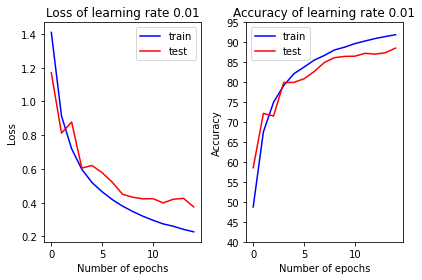

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of learning rate 0.01")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of learning rate 0.01")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))

fig.tight_layout()
plt.show()


## 3. LR_3 = 0.1

In [ ]:
%%time
epoch15 = config['epoch'][0]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer3 = optim.SGD(res18.parameters(), lr=config['lr'][2], momentum=config['momentum'])

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch15+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, trainloader, optimizer3, DEVICE, None) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()

# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)
        
RESULTS['LR_3'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)
save_checkpoint(res18, test_acc[-1], epoch15, 'LR_3')

Epoch: 001 | Epoch Time: 0m 38s
	Train Loss: 2.0317 | Train Acc: 28.07%
	Valid Loss: 1.6082 | Valid Acc: 40.28%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 1.5364 | Train Acc: 42.95%
	Valid Loss: 1.3636 | Valid Acc: 50.33%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 1.2931 | Train Acc: 53.10%
	Valid Loss: 1.2056 | Valid Acc: 56.49%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 1.0768 | Train Acc: 61.54%
	Valid Loss: 1.0714 | Valid Acc: 61.62%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.9278 | Train Acc: 67.14%
	Valid Loss: 0.8709 | Valid Acc: 69.28%



In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of learning rate 0.1")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of learning rate 0.1")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))

fig.tight_layout()
plt.show()

# 4. 4.Learning Rate Schedule
Because Training Loss under lr=0.01 is the best, we use it as the initial learning rate below.

## 1. Constant Learning rate(0.01)

In [22]:
%%time
best_lr = 0.01
epoch300 = config['epoch'][1]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer4 = optim.SGD(res18.parameters(), lr=best_lr, momentum=config['momentum'])

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch300+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, trainloader, optimizer4, DEVICE, None) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()

# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)
        
RESULTS['SCHD_1'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)
save_checkpoint(res18, test_acc[-1], epoch300, 'SCHD_1')

Epoch: 001 | Epoch Time: 0m 38s
	Train Loss: 1.4568 | Train Acc: 46.57%
	Valid Loss: 1.2037 | Valid Acc: 58.27%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 0.9590 | Train Acc: 65.70%
	Valid Loss: 0.8398 | Valid Acc: 70.40%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 0.7309 | Train Acc: 74.32%
	Valid Loss: 0.7951 | Valid Acc: 72.80%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 0.6097 | Train Acc: 78.77%
	Valid Loss: 0.7825 | Valid Acc: 75.01%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.5279 | Train Acc: 81.83%
	Valid Loss: 0.5862 | Valid Acc: 80.24%

Epoch: 006 | Epoch Time: 0m 38s
	Train Loss: 0.4704 | Train Acc: 83.73%
	Valid Loss: 0.5093 | Valid Acc: 82.70%

Epoch: 007 | Epoch Time: 0m 38s
	Train Loss: 0.4198 | Train Acc: 85.45%
	Valid Loss: 0.5076 | Valid Acc: 83.32%

Epoch: 008 | Epoch Time: 0m 38s
	Train Loss: 0.3767 | Train Acc: 87.01%
	Valid Loss: 0.4565 | Valid Acc: 85.03%

Epoch: 009 | Epoch Time: 0m 38s
	Train Loss: 0.3518 | Train Acc: 87.72%
	Valid Loss: 0.4437 | Va

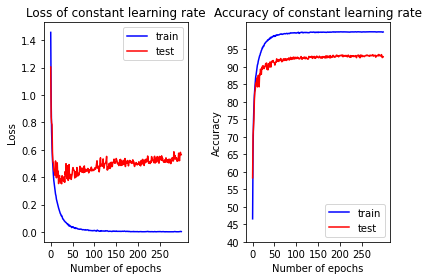

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of constant learning rate")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))
ax[0].set_xticks(np.arange(0, 300, 50))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of constant learning rate")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))
ax[1].set_xticks(np.arange(0, 300, 50))

fig.tight_layout()
plt.show()

## 2. Learning rate(0.01) with cosine annealing

In [ ]:
%%time
best_lr = 0.01
epoch300 = config['epoch'][1]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer5 = optim.SGD(res18.parameters(), lr=best_lr, momentum=config['momentum'])

# Cosine decay for the learning rate
scheduler5 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer5, T_max=epoch300, eta_min=0)


train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch300+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, trainloader, optimizer5, DEVICE, scheduler5) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()

# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)
        
RESULTS['SCHD_2'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)
save_checkpoint(res18, test_acc[-1], epoch300, 'SCHD_2')

Epoch: 001 | Epoch Time: 0m 38s
	Train Loss: 1.4315 | Train Acc: 47.78%
	Valid Loss: 1.2365 | Valid Acc: 56.93%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 0.9251 | Train Acc: 66.98%
	Valid Loss: 0.9873 | Valid Acc: 68.44%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 0.7037 | Train Acc: 75.68%
	Valid Loss: 0.9670 | Valid Acc: 70.24%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 0.5861 | Train Acc: 79.47%
	Valid Loss: 0.5934 | Valid Acc: 79.96%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.5102 | Train Acc: 82.25%
	Valid Loss: 0.5954 | Valid Acc: 80.22%

Epoch: 006 | Epoch Time: 0m 38s
	Train Loss: 0.4614 | Train Acc: 83.88%
	Valid Loss: 0.5823 | Valid Acc: 81.29%

Epoch: 007 | Epoch Time: 0m 38s
	Train Loss: 0.4044 | Train Acc: 85.94%
	Valid Loss: 0.5605 | Valid Acc: 82.07%

Epoch: 008 | Epoch Time: 0m 38s
	Train Loss: 0.3765 | Train Acc: 86.95%
	Valid Loss: 0.4337 | Valid Acc: 85.51%

Epoch: 009 | Epoch Time: 0m 38s
	Train Loss: 0.3431 | Train Acc: 88.07%
	Valid Loss: 0.4885 | Va

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of learning rate with cosine annealing")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))
ax[0].set_xticks(np.arange(0, 300, 50))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of learning rate with cosine annealing")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))
ax[1].set_xticks(np.arange(0, 300, 50))

fig.tight_layout()
plt.show()

刷新一下train函数和config配置

# 5. 5. Weight decay

## WD_1 = 5e-4

In [19]:
%%time
best_lr = 0.01
WD = config['weight_decay'][0]
epoch300 = config['epoch'][1]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer6 = optim.SGD(res18.parameters(), lr=best_lr, momentum=config['momentum'], weight_decay=WD)

# Cosine decay for the learning rate
scheduler6 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer6, T_max=epoch300, eta_min=0)


train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch300+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, trainloader, optimizer6, DEVICE, scheduler6) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()

# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)
        
RESULTS['WD_1'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)

save_checkpoint(res18, test_acc[-1], epoch300, 'WD_1')

Epoch: 001 | Epoch Time: 0m 39s
	Train Loss: 1.4134 | Train Acc: 48.71%
	Valid Loss: 1.1779 | Valid Acc: 59.93%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 0.9164 | Train Acc: 67.82%
	Valid Loss: 0.8161 | Valid Acc: 72.14%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 0.7079 | Train Acc: 75.22%
	Valid Loss: 0.6629 | Valid Acc: 77.07%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 0.5925 | Train Acc: 79.47%
	Valid Loss: 0.6531 | Valid Acc: 78.13%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.5199 | Train Acc: 81.99%
	Valid Loss: 0.5466 | Valid Acc: 81.72%

Epoch: 006 | Epoch Time: 0m 38s
	Train Loss: 0.4609 | Train Acc: 84.14%
	Valid Loss: 0.4793 | Valid Acc: 83.31%

Epoch: 007 | Epoch Time: 0m 38s
	Train Loss: 0.4195 | Train Acc: 85.39%
	Valid Loss: 0.6210 | Valid Acc: 80.53%

Epoch: 008 | Epoch Time: 0m 38s
	Train Loss: 0.3829 | Train Acc: 86.78%
	Valid Loss: 0.5385 | Valid Acc: 82.95%

Epoch: 009 | Epoch Time: 0m 38s
	Train Loss: 0.3482 | Train Acc: 87.89%
	Valid Loss: 0.5753 | Va

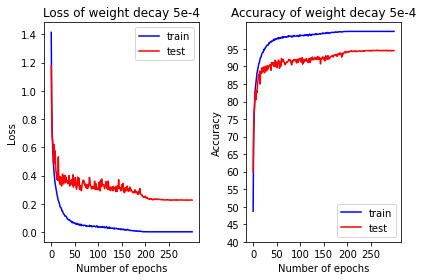

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of weight decay 5e-4")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))
ax[0].set_xticks(np.arange(0, 300, 50))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of weight decay 5e-4")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))
ax[1].set_xticks(np.arange(0, 300, 50))

fig.tight_layout()
plt.show()

In [21]:
print(RESULTS)

{'LR_1': [[1.6226971509206631, 1.1886510295636208, 0.9697680177591036, 0.8240031836282872, 0.7202171399770185, 0.6433868354848583, 0.5933846421253955, 0.543402303820071, 0.5063044771818859, 0.472277841299696, 0.44308168839310746, 0.4194347218174459, 0.39121313457903656, 0.3720373035315662, 0.35351174540074587], [40.26, 57.156, 65.334, 71.004, 74.65, 77.45, 79.258, 81.12, 82.632, 83.572, 84.562, 85.256, 86.362, 87.166, 87.884], [1.5101275324821473, 1.1924592435359955, 0.9308565348386765, 0.8558651387691498, 0.7302664712071418, 0.7692529261112213, 0.6490520417690278, 0.6410447515547275, 0.6410339117050171, 0.6207211330533028, 0.5319946676492691, 0.5609146349132061, 0.4956565387547016, 0.45513352304697036, 0.4887926265597343], [45.45, 58.0, 67.23, 70.42, 75.03, 74.68, 77.73, 77.62, 78.09, 79.83, 81.9, 81.34, 83.59, 84.52, 83.46]], 'LR_2': [[1.409380871316661, 0.9141419039053076, 0.7192021502405787, 0.5981200182681803, 0.5196575871513932, 0.46467253550544113, 0.41823967971155407, 0.3802513

## 2. WD_2 = 1e-2

In [22]:
%%time
best_lr = 0.01
WD = config['weight_decay'][1]
epoch300 = config['epoch'][1]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer7 = optim.SGD(res18.parameters(), lr=best_lr, momentum=config['momentum'], weight_decay=WD)

# Cosine decay for the learning rate
scheduler7 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer7, T_max=epoch300, eta_min=0)


train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch300+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, trainloader, optimizer7, DEVICE, scheduler7) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()

# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)
        
RESULTS['WD_2'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)

save_checkpoint(res18, test_acc[-1], epoch300, 'WD_2')

Epoch: 001 | Epoch Time: 0m 38s
	Train Loss: 1.4433 | Train Acc: 47.38%
	Valid Loss: 1.2170 | Valid Acc: 56.98%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 0.9668 | Train Acc: 65.89%
	Valid Loss: 1.0017 | Valid Acc: 66.63%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 0.7689 | Train Acc: 73.22%
	Valid Loss: 0.8200 | Valid Acc: 71.73%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 0.6858 | Train Acc: 76.52%
	Valid Loss: 0.9665 | Valid Acc: 67.35%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.6320 | Train Acc: 78.89%
	Valid Loss: 0.8534 | Valid Acc: 70.85%

Epoch: 006 | Epoch Time: 0m 38s
	Train Loss: 0.6068 | Train Acc: 79.91%
	Valid Loss: 0.7635 | Valid Acc: 73.74%

Epoch: 007 | Epoch Time: 0m 38s
	Train Loss: 0.5886 | Train Acc: 80.55%
	Valid Loss: 0.8284 | Valid Acc: 72.50%

Epoch: 008 | Epoch Time: 0m 38s
	Train Loss: 0.5775 | Train Acc: 80.75%
	Valid Loss: 0.7588 | Valid Acc: 74.08%

Epoch: 009 | Epoch Time: 0m 38s
	Train Loss: 0.5637 | Train Acc: 81.51%
	Valid Loss: 1.0086 | Va

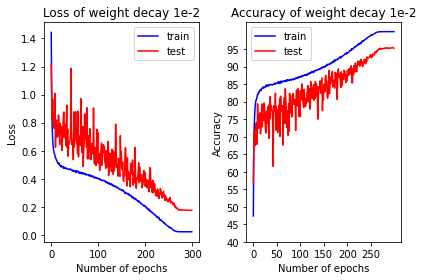

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of weight decay 1e-2")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))
ax[1].set_xticks(np.arange(0, 300, 50))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy of weight decay 1e-2")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))
ax[1].set_xticks(np.arange(0, 300, 50))

fig.tight_layout()
plt.show()

# 6. 6. Data Augmentation

In [24]:
DA_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

DA_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=DA_transform_train)
DA_trainloader = torch.utils.data.DataLoader(
    DA_trainset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [25]:
%%time
best_lr = 0.01
WD = config['weight_decay'][1] #1e-2
epoch300 = config['epoch'][1]
res18 = ResNet18().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
# diff
optimizer8 = optim.SGD(res18.parameters(), lr=best_lr, momentum=config['momentum'], weight_decay=WD)

# Cosine decay for the learning rate
scheduler8 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer8, T_max=epoch300, eta_min=0)


train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(1, epoch300+1):
    start_time = time.time()
    train_loss_, train_acc_ = train(epoch, res18, criterion, DA_trainloader, optimizer8, DEVICE, scheduler8) # diff
    test_loss_, test_acc_ = test(epoch, res18, criterion, testloader, DEVICE)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save results
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    #print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
    #  ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    print(f'Epoch: {epoch:03} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_:.4f} | Train Acc: {train_acc_:2.2f}%')
    print(f'\tValid Loss: {test_loss_:.4f} | Valid Acc: {test_acc_:2.2f}%')
    print()

# load DL_result.json into RESULTS
if RESULT_FILENAME in os.listdir(root):
    with open(root + RESULT_FILENAME, 'r') as f:
        RESULTS = json.load(f)
        
RESULTS['DA'] =  [train_loss, train_acc, test_loss, test_acc] #diff

# write 'RESULTS' into 'DL_result.json' file
with open(root + RESULT_FILENAME, 'w') as f:
    json.dump(RESULTS, f)

save_checkpoint(res18, test_acc[-1], epoch300, 'DA')

Epoch: 001 | Epoch Time: 0m 39s
	Train Loss: 1.6116 | Train Acc: 40.41%
	Valid Loss: 1.3301 | Valid Acc: 54.48%

Epoch: 002 | Epoch Time: 0m 38s
	Train Loss: 1.2135 | Train Acc: 56.42%
	Valid Loss: 1.4098 | Valid Acc: 54.80%

Epoch: 003 | Epoch Time: 0m 38s
	Train Loss: 1.0240 | Train Acc: 63.70%
	Valid Loss: 1.0962 | Valid Acc: 63.12%

Epoch: 004 | Epoch Time: 0m 38s
	Train Loss: 0.9239 | Train Acc: 67.84%
	Valid Loss: 0.8220 | Valid Acc: 71.45%

Epoch: 005 | Epoch Time: 0m 38s
	Train Loss: 0.8661 | Train Acc: 70.25%
	Valid Loss: 1.0561 | Valid Acc: 64.07%

Epoch: 006 | Epoch Time: 0m 38s
	Train Loss: 0.8369 | Train Acc: 71.46%
	Valid Loss: 0.9879 | Valid Acc: 66.85%

Epoch: 007 | Epoch Time: 0m 38s
	Train Loss: 0.8191 | Train Acc: 72.02%
	Valid Loss: 0.9535 | Valid Acc: 66.71%

Epoch: 008 | Epoch Time: 0m 38s
	Train Loss: 0.8091 | Train Acc: 72.42%
	Valid Loss: 0.7396 | Valid Acc: 74.62%

Epoch: 009 | Epoch Time: 0m 38s
	Train Loss: 0.7947 | Train Acc: 73.08%
	Valid Loss: 0.7808 | Va

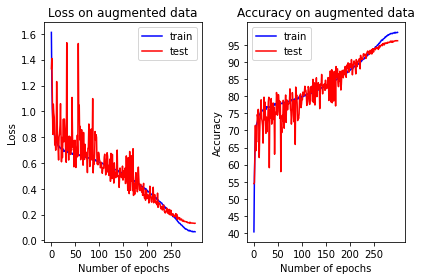

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(train_loss)), train_loss, 'b')
ax[0].plot(range(len(test_loss)), test_loss, 'r')
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss on augmented data")
ax[0].legend(['train', 'test'])
#ax[0].set_yticks(np.arange(0.4, 1.6, 0.1))
ax[0].set_xticks(np.arange(0, 300, 50))

ax[1].plot(range(len(train_acc)), train_acc, 'b')
ax[1].plot(range(len(test_acc)), test_acc, 'r')
ax[1].set_xlabel("Number of epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy on augmented data")
ax[1].legend(['train', 'test'])
ax[1].set_yticks(np.arange(40, 100, 5))
ax[1].set_xticks(np.arange(0, 300, 50))

fig.tight_layout()
plt.show()

In [28]:
print(len(RESULTS))

8
